<a href="https://colab.research.google.com/github/ShreyaMandot/Topic-Modelling-Using-LDA-Top2Vec-BERTopic/blob/main/LDA_TF_idf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
import os.path
import re
import spacy
import pandas as pd
import nltk
from gensim import corpora
from gensim.models import LsiModel
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
import pprint
import gensim, spacy, logging, warnings
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from pprint import pprint
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
 

/usr/local/lib/python3.8/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [3]:
df=pd.read_csv('/content/Clean_Tweets.csv')
tweets_df=df.loc[:,['new_text']]
#tweets_df.info()

tweets_df['new_text']= df['new_text'].str.lower()

# Convert to list
data = tweets_df.new_text.values.tolist()

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

data_words1 = remove_stopwords(data_words)


def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

nlp = spacy.load("en_core_web_sm")

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words1, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

dictionary = gensim.corpora.Dictionary(data_lemmatized)

corpus = [dictionary.doc2bow(doc) for doc in data_lemmatized]


from gensim import corpora, models
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]
from pprint import pprint
for doc in corpus_tfidf:
    pprint(doc)
    break



[(0, 0.3659217384485074),
 (1, 0.3553631837594383),
 (2, 0.6874354314295279),
 (3, 0.5169630708033957)]


In [5]:

lda_model = gensim.models.LdaMulticore(corpus_tfidf, num_topics=65, id2word=dictionary, 
                                       random_state=100,
                                           chunksize=100,
                                           passes=2,
                                           per_word_topics=True)
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))


Topic: 0 Word: 0.072*"real" + 0.072*"people" + 0.055*"pill" + 0.049*"name" + 0.033*"life" + 0.032*"wellbutrin" + 0.027*"least" + 0.026*"extreme" + 0.023*"girl" + 0.020*"drug"
Topic: 1 Word: 0.074*"pass" + 0.051*"see" + 0.044*"hope" + 0.043*"doctor" + 0.035*"lot" + 0.031*"community" + 0.029*"become" + 0.023*"explain" + 0.022*"review" + 0.022*"recently"
Topic: 2 Word: 0.071*"medically" + 0.063*"consider" + 0.056*"care" + 0.046*"drink" + 0.033*"likely" + 0.029*"twice" + 0.022*"alcohol" + 0.013*"worried" + 0.013*"repeatedly" + 0.011*"art"
Topic: 3 Word: 0.156*"patch" + 0.032*"reason" + 0.030*"patent" + 0.028*"company" + 0.027*"sorry" + 0.026*"thenreport" + 0.026*"serious" + 0.024*"monitor" + 0.022*"netizensreport" + 0.022*"acoty"
Topic: 4 Word: 0.079*"manager" + 0.051*"take" + 0.044*"time" + 0.042*"day" + 0.041*"year" + 0.040*"sleep" + 0.032*"night" + 0.032*"fuck" + 0.032*"last" + 0.029*"month"
Topic: 5 Word: 0.040*"knowledge" + 0.026*"metabolize" + 0.026*"talk" + 0.021*"morning" + 0.021*"

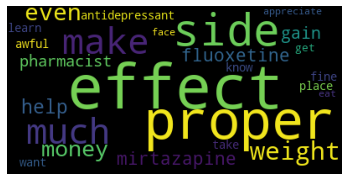

In [13]:
from wordcloud import WordCloud
wordcloud = WordCloud()
wordcloud.generate_from_frequencies(dict(lda_model.show_topic(38, topn=25)))

# Display the wordcloud
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [ ]:
print('\nPerplexity: ', lda_model.log_perplexity(corpus_tfidf))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)



Perplexity:  -18.149385883073574

Coherence Score:  0.5147682705232106


In [ ]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_lemmatized)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(20)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,39.0,0.3845,"adderall, lol, day, take, literally, new, feel...","[day, withdrawal, feel, sick]"
1,1,36.0,0.8031,"change, away, sleep, weird, listen, abilify, s...","[go, convince, change, soon]"
2,2,46.0,0.5026,"noahpinion, treatment, kill, greedyalmighty, c...","[line, wait, escitalopram, poise, kill]"
3,3,18.0,0.5038,"ignore, doctor, corruption, amphetamine, zolof...","[exam, amp, escitalopram]"
4,4,46.0,0.6256,"noahpinion, treatment, kill, greedyalmighty, c...","[thank, know, balanced, arm, randomise, escita..."
5,5,22.0,0.6079,"negative, adhd, good, wellbutrin, consult, wel...","[effect, escitalopram, treatment, chronic, mil..."
6,6,24.0,0.7279,"option, person, couple, actual, safe, ocd, exp...","[nephrosafe, escitalopram, sertraline, safe, t..."
7,7,22.0,0.6301,"negative, adhd, good, wellbutrin, consult, wel...","[escitalopram, never, really, do, shit, m, try..."
8,8,33.0,0.3530,"forget, hit, combine, recommend, wellbutrin, c...","[fix, lexapro]"
9,9,43.0,0.7052,"amp, thank, parkinson, man, little, simvastate...","[bipolaritycheck, bipolar, amp, take, lithium,..."


In [ ]:
!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models

pyLDAvis.enable_notebook()

vis=pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary, mds="mmds", R=20 )
vis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 26.0 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=1f0e9f33b26bcb46e7dab28d7b44000107beeea757d9ccc2bb4efa8633e86e38
  Stored in directory: /root/.cache/pip/wheels/90/61/ec/9dbe9efc3acf9c4e37ba70fbbcc3f3a0ebd121060aa593181a
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=58c32afeabe43bda5b80686c18c696336de6ffc41c36229d38b5f23a598ab428
  Stored in directory: /root/.cache/pip/wheels/14/25/f7/1cc0956978ae479e75140219088deb7a36f60459df242b1a72
Successfully built pyLDAvis sklearn


/usr/local/lib/python3.8/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  from collections import Iterable
/usr/local/lib/python3.8/dist-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
22    -0.009219  0.440113       1        1  6.399901
4      0.307744  0.305473       2        1  5.177551
5     -0.204939  0.375268       3        1  4.118209
38    -0.101226  0.396350       4        1  3.585740
39     0.317745 -0.041561       5        1  2.691210
...         ...       ...     ...      ...       ...
14     0.049614 -0.042588      61        1  0.636596
59     0.099830  0.018643      62        1  0.563158
56    -0.111245  0.097539      63        1  0.489795
42    -0.390777 -0.089181      64        1  0.399526
64     0.000303 -0.037408      65        1  0.328546

[65 rows x 5 columns], topic_info=                Term        Freq       Total Category  logprob  loglift
220       wellbutrin  978.000000  978.000000  Default  20.0000  20.0000
1344       bupropion  593.000000  593.000000  Default  19.0000  19.0000
826            study  494.000000  494.000000  Default  18.0000  18.0000
6372           emsam  301.000000  301.000000  Default  17.0000  17.0000
1226           paxil  333.000000  333.000000  Default  16.0000  16.0000
...              ...         ...         ...      ...      ...      ...
3902             era    2.149968    4.656594  Topic65  -5.0339   4.9454
9734          bghgmg    2.745058    6.175204  Topic65  -4.7896   4.9075
9145           duvet    1.676152    4.245616  Topic65  -5.2829   4.7889
7989          lonely    1.167391    3.674809  Topic65  -5.6446   4.5715
9498  confesstoaubry    1.591534    5.107816  Topic65  -5.3347   4.5522

[1533 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
989      16  0.947004       abilify
761      51  0.786671       ability
538      42  0.942660          able
4850     57  0.724301       absence
4621     42  0.764970      absolute
...     ...       ...           ...
9810     56  0.726629  yourgirlkate
1500     49  0.750282           zap
1113      1  0.244211        zoloft
1113     27  0.732634        zoloft
2262     62  0.687783          zoom

[1865 rows x 3 columns], R=20, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[23, 5, 6, 39, 40, 48, 55, 28, 54, 64, 29, 61, 9, 22, 8, 37, 12, 17, 1, 26, 53, 20, 30, 44, 2, 24, 19, 18, 13, 52, 51, 31, 33, 32, 27, 41, 47, 21, 45, 46, 3, 7, 56, 36, 4, 59, 58, 34, 38, 35, 63, 11, 25, 42, 14, 16, 10, 50, 62, 49, 15, 60, 57, 43, 65])